## import libraries

In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import missingno as msno 
import seaborn as sns
import matplotlib.pyplot as plt 

#sklearn

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score

#imbalanced learning
from imblearn.ensemble import EasyEnsembleClassifier

# import custom functions
from custom_functions import get_data_summary, our_metrics, eval_metrics, class_metrics_var_threshold#, evaluate_model

# import custom scorers
from custom_functions import get_f15, get_f2, get_f3



# import warnings
# warnings.filterwarnings('ignore')

In [2]:
# for reproducibility sake
RSEED = 42

## Make scorer Fbeta

In [3]:
# make the Fbeta scorers needed for the grid search
f15_scorer = get_f15()
ftwo_scorer = get_f2()
fthree_scorer = get_f3()

# Import test and train data, target

In [4]:
# # Don't use storemagic (%store -r <filename>) for lare Dataframes /Arrays, it will keep crashing!
# # %store shows all stored variables. 
# # %store -z deletes all stored variables from memory

In [4]:
# reading in the whole data set
X_train_tree = pd.read_csv('data/X_train_tree.csv', delimiter=',')
X_test_tree = pd.read_csv('data/X_test_tree.csv', delimiter=',')
y_test_tree = pd.read_csv('data/y_test_tree.csv', delimiter=',')
y_train_tree = pd.read_csv('data/y_train_tree.csv', delimiter=',')

In [5]:
# reading in the partial data sets
X_train_tree_large = pd.read_csv('data/X_train_tree_large.csv', delimiter=',')#
y_train_tree_large = pd.read_csv('data/y_train_tree_large.csv', delimiter=',')#
X_train_tree_small = pd.read_csv('data/X_train_tree_small.csv', delimiter=',')#
y_train_tree_small = pd.read_csv('data/y_train_tree_small.csv', delimiter=',')#

In [6]:
# change format of y from dataframe to array
y_test_tree = np.ravel(y_test_tree)
y_train_tree = np.ravel(y_train_tree)

In [7]:
y_test_tree

array([0, 0, 0, ..., 0, 0, 0])

## EasyEnsembleClassifier

### What is the EasyEnsembleClassifier?

* Machine Learning Model for imbalanced data
* Bag of balanced boosted learners.
* Ensemble of AdaBoost learners trained on different balanced bootstrap samples. The balancing is achieved by random under-sampling.

### AdaBoostClassifier

[scikit-learn documentation](https://scikit-learn.org/stable/modules/ensemble.html#adaboost)
The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. The data modifications at each so-called boosting iteration consist of applying weights , , …,  to each of the training samples. Initially, those weights are all set to , so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence.

 By default, weak learners are decision stumps. Different weak learners can be specified through the estimator parameter. The main parameters to tune to obtain good results are n_estimators and the complexity of the base estimators (e.g., its depth max_depth or minimum required number of samples to consider a split min_samples_split).

The individual learners can be weak, but as long as the performance of each one is slightly better than random guessing, the final model can be proven to converge to a strong learner.

## Single EnsembleClassifier

training an EasyEnsemble Classifier with the whole X_train with default setting, without hyperparameter tuning.

In [8]:
# initiate EasyEnsembleClassifier
eec = EasyEnsembleClassifier(random_state=RSEED)

In [ ]:
# no more NaN values since cleaned out in cleaning NB
# X_train_tree.isnull().sum()

In [10]:
# X_train_tree.loc[X_train_tree.isnull().any(axis=1)]

,member_years,index_change_month,quantity_counters,client_catg_11,client_catg_12,client_catg_51,region_101,region_103,region_104,region_105,...,counter_statue_2.0,counter_statue_3.0,counter_statue_4.0,counter_statue_5.0,reading_remarque_6,reading_remarque_7,reading_remarque_8,reading_remarque_9,counter_type_ELEC,counter_type_GAZ


In [12]:
# fit eec to train data
eec.fit(X_train_tree, y_train_tree)
# make prediction on test data
y_pred_eec = eec.predict(X_test_tree)

In [25]:
y_pred_train_eec = eec.predict(X_train_tree)

Performance on Train Set
Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.6084
_____________________
F1-score: 0.2033
_____________________
Fbeta_score with beta=1.5: 0.2752
_____________________
Fbeta_score with beta=2: 0.3431
_____________________
Fbeta_score with beta=3: 0.4451
_____________________
Recall 0.6335
_____________________
Specificity 0.6063


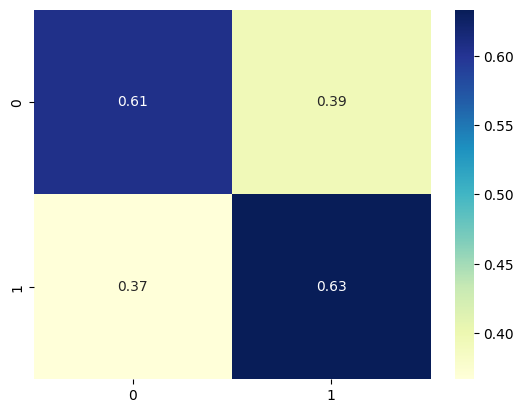

In [109]:
print('Performance on Train Set')
our_metrics(y_train_tree, y_pred_train_eec)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.6089
_____________________
F1-score: 0.204
_____________________
Fbeta_score with beta=1.5: 0.2761
_____________________
Fbeta_score with beta=2: 0.3442
_____________________
Fbeta_score with beta=3: 0.4465
_____________________
Recall 0.6353
_____________________
Specificity 0.6067


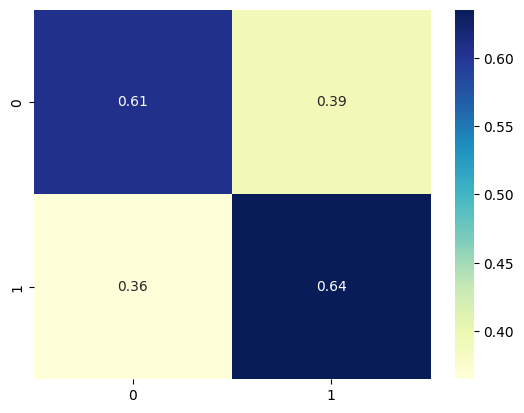

In [13]:
# get performance metrics
print('Performance on Test Set')
our_metrics(y_test_tree, y_pred_eec)
# print confusion matrix
# print(confusion_matrix(y_test, y_pred))

In [24]:
# print(f'Number of AdaBoostClassifiers of the Model:{len(eec.estimators_)}')
# n_adas = []

# for ind_ada in eec.estimators_:
#     n_adas.append(len(ind_ada.estimators_))
#     # for ind_tree in ind_ada.estimators_:
#     #     n_nodes.append(ind_tree.tree_.node_count)
#     #     max_depths.append(ind_tree.tree_.max_depth)
#     # print(f'Average number of nodes {int(np.mean(n_nodes))}')
#     # print(f'Average maximum depth {int(np.mean(max_depths))}')
#     print(f'Average number of DecisionTreeClassifiers per AdaBoostClassifier {int(np.mean(n_adas))}')

Number of AdaBoostClassifiers of the Model:10


## Hyperparameter Tuning - RandomSearch

In [15]:
# to see the list of hyperparameters that can be tuned
#eec_rs.get_params()

### Hyperparameters of the EasyEnsembleClassifier

* 'base_estimator': 'deprecated', now 'estimator'
* 'estimator': None, default=AdaBoostClassifier()
* 'n_estimators': default=10, Number of AdaBoost learners in the ensemble.
* 'n_jobs': default=None, Number of CPU cores used during the cross-validation loop. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.
* 'random_state': default=None, If None, the random number generator is the RandomState instance used by np.random.
* 'replacement': default=False, Whether or not to sample randomly with replacement or not.
* 'sampling_strategy': default='auto'equivalent to 'not minority', Sampling information to sample the data set. float, str, dict, callable, default=’auto’. When float, it corresponds to the desired ratio of the number of samples in the minority class over the number of samples in the majority class after resampling. Therefore, the ratio is expressed as $N_m/N_{rM}$,
 where $N_m$ is the number of samples in the minority class and $N_{rM}$ is the number of samples in the majority class after resampling.
* 'verbose': default=0, Controls the verbosity of the building process.
* 'warm_start': default=False. When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new ensemble.

In [123]:
# Define parameter grid for randomized search
# sampling_strategy=0.5 yields very poor results, is removed. score 0.147-0.162
# sampling_strategy=1.5 yields error, probably because this ratio cannot be achieved by the dataset, is removed.
# sampling_strategy=1.2 yields error, probably because this ratio cannot be achieved by the dataset, is removed.
# n_estimators 14 give no gain in scores, take a long time. can be removed
param_grid = { "sampling_strategy" : ['auto', 0.8, 1],
            "replacement" : [False, True],
                "n_estimators" : [5, 6, 8, 10, 12]}

In [34]:
# # Instantiate stratified CV. if to use, use cv=cv in RandomizedSearch
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RSEED)

### Hyperparameter tuning using the F2 scorer

In [37]:
# Instantiate random search and define the metric to optimize 
rs = RandomizedSearchCV(EasyEnsembleClassifier(random_state=RSEED), param_grid, scoring=ftwo_scorer,
                  cv=5, verbose=5, n_jobs=1, n_iter=10, random_state=RSEED) #cv=5

In [38]:
# Fit randomized search object to data
rs.fit(X_train_tree_small, y_train_tree_small)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END n_estimators=6, replacement=False, sampling_strategy=auto;, score=0.341 total time=  29.0s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END n_estimators=6, replacement=False, sampling_strategy=auto;, score=0.342 total time=  28.9s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END n_estimators=6, replacement=False, sampling_strategy=auto;, score=0.347 total time=  28.6s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END n_estimators=6, replacement=False, sampling_strategy=auto;, score=0.341 total time=  29.1s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END n_estimators=6, replacement=False, sampling_strategy=auto;, score=0.347 total time=  28.0s
[CV 1/5] END n_estimators=6, replacement=False, sampling_strategy=1.5;, score=nan total time=   0.1s
[CV 2/5] END n_estimators=6, replacement=False, sampling_strategy=1.5;, score=nan total time=   0.1s
[CV 3/5] END n_estimators=6, replacement=False, sampling_strategy=1.5;, score=nan total time=   0.1s
[CV 4/5] END n_estimators=6, replacement=False, sampling_strategy=1.5;, score=nan total time=   0.1s
[CV 5/5] END n_estimators=6, replacement=False, sampling_strategy=1.5;, score=nan total time=   0.1s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END n_estimators=12, replacement=False, sampling_strategy=auto;, score=0.341 total time=  55.6s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END n_estimators=12, replacement=False, sampling_strategy=auto;, score=0.342 total time=  56.7s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END n_estimators=12, replacement=False, sampling_strategy=auto;, score=0.346 total time=  57.2s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END n_estimators=12, replacement=False, sampling_strategy=auto;, score=0.340 total time=  57.3s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END n_estimators=12, replacement=False, sampling_strategy=auto;, score=0.347 total time=  56.9s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END n_estimators=12, replacement=True, sampling_strategy=1;, score=0.341 total time=  57.5s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END n_estimators=12, replacement=True, sampling_strategy=1;, score=0.341 total time=  58.0s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END n_estimators=12, replacement=True, sampling_strategy=1;, score=0.347 total time=  57.5s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END n_estimators=12, replacement=True, sampling_strategy=1;, score=0.341 total time=  57.3s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END n_estimators=12, replacement=True, sampling_strategy=1;, score=0.348 total time=  56.9s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END n_estimators=8, replacement=False, sampling_strategy=0.5;, score=0.147 total time=  56.4s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END n_estimators=8, replacement=False, sampling_strategy=0.5;, score=0.157 total time=  56.6s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END n_estimators=8, replacement=False, sampling_strategy=0.5;, score=0.158 total time=  56.1s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END n_estimators=8, replacement=False, sampling_strategy=0.5;, score=0.159 total time=  56.7s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END n_estimators=8, replacement=False, sampling_strategy=0.5;, score=0.162 total time=  57.9s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END n_estimators=14, replacement=True, sampling_strategy=auto;, score=0.340 total time= 1.1min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END n_estimators=14, replacement=True, sampling_strategy=auto;, score=0.341 total time= 1.1min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END n_estimators=14, replacement=True, sampling_strategy=auto;, score=0.347 total time= 1.1min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END n_estimators=14, replacement=True, sampling_strategy=auto;, score=0.341 total time= 1.1min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END n_estimators=14, replacement=True, sampling_strategy=auto;, score=0.348 total time= 1.1min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END n_estimators=10, replacement=True, sampling_strategy=1;, score=0.341 total time=  46.7s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END n_estimators=10, replacement=True, sampling_strategy=1;, score=0.341 total time=  47.1s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END n_estimators=10, replacement=True, sampling_strategy=1;, score=0.346 total time=  47.0s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END n_estimators=10, replacement=True, sampling_strategy=1;, score=0.341 total time=  46.8s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END n_estimators=10, replacement=True, sampling_strategy=1;, score=0.348 total time=  46.6s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END n_estimators=14, replacement=False, sampling_strategy=auto;, score=0.341 total time= 1.1min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END n_estimators=14, replacement=False, sampling_strategy=auto;, score=0.342 total time= 1.1min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END n_estimators=14, replacement=False, sampling_strategy=auto;, score=0.346 total time= 6.0min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END n_estimators=14, replacement=False, sampling_strategy=auto;, score=0.340 total time= 5.4min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END n_estimators=14, replacement=False, sampling_strategy=auto;, score=0.347 total time= 1.1min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END n_estimators=8, replacement=False, sampling_strategy=auto;, score=0.341 total time=  37.6s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END n_estimators=8, replacement=False, sampling_strategy=auto;, score=0.342 total time=  37.1s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END n_estimators=8, replacement=False, sampling_strategy=auto;, score=0.347 total time=  37.1s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END n_estimators=8, replacement=False, sampling_strategy=auto;, score=0.340 total time=  37.1s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END n_estimators=8, replacement=False, sampling_strategy=auto;, score=0.347 total time=  37.1s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END n_estimators=14, replacement=True, sampling_strategy=1;, score=0.340 total time= 1.1min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END n_estimators=14, replacement=True, sampling_strategy=1;, score=0.341 total time= 1.1min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END n_estimators=14, replacement=True, sampling_strategy=1;, score=0.347 total time= 1.1min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END n_estimators=14, replacement=True, sampling_strategy=1;, score=0.341 total time= 1.1min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END n_estimators=14, replacement=True, sampling_strategy=1;, score=0.348 total time= 1.1min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/imblearn/utils/fixes.py", line 78, in wrapper
    estimator._validate_params()

RandomizedSearchCV(cv=5, estimator=EasyEnsembleClassifier(random_state=42),
                   n_jobs=1,
                   param_distributions={'n_estimators': [6, 8, 10, 12, 14],
                                        'replacement': [False, True],
                                        'sampling_strategy': ['auto', 0.5, 0.8,
                                                              1, 1.2, 1.5]},
                   random_state=42, scoring=make_scorer(fbeta_score, beta=2),
                   verbose=5)

In [39]:
# Best score
print('Best score (F2):', round(rs.best_score_, 3))

# Best parameters
print('Best parameters:', rs.best_params_)


# Assigning the fitted EasyEnsemble model with best parameter combination to a new variable sgd_best_rs
eec_best_rs = rs.best_estimator_

# Best score (F2): 0.344
# Best parameters: {'sampling_strategy': 'auto', 'replacement': False, 'n_estimators': 6}


Best score (F2): 0.344
Best parameters: {'sampling_strategy': 'auto', 'replacement': False, 'n_estimators': 6}


In [110]:
# pd.DataFrame(rs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sampling_strategy,param_replacement,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,24.674976,0.385618,4.055783,0.031895,auto,False,6,"{'sampling_strategy': 'auto', 'replacement': F...",0.341466,0.341968,0.347311,0.340704,0.346980,0.343686,0.002855,1
1,0.079664,0.020227,0.000000,0.000000,1.5,False,6,"{'sampling_strategy': 1.5, 'replacement': Fals...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
2,48.627287,0.512083,8.120380,0.102189,auto,False,12,"{'sampling_strategy': 'auto', 'replacement': F...",0.340702,0.342124,0.346242,0.340185,0.346903,0.343231,0.002809,7
3,49.398040,0.321447,8.054350,0.052197,1,True,12,"{'sampling_strategy': 1, 'replacement': True, ...",0.340619,0.341292,0.346818,0.341045,0.347792,0.343513,0.003119,2
4,51.326847,0.499438,5.426844,0.125236,0.5,False,8,"{'sampling_strategy': 0.5, 'replacement': Fals...",0.147146,0.157463,0.158150,0.159184,0.162164,0.156821,0.005097,9
5,56.734713,1.205055,9.451854,0.231032,auto,True,14,"{'sampling_strategy': 'auto', 'replacement': T...",0.340484,0.341219,0.346562,0.340896,0.347641,0.343360,0.003082,4
6,40.159334,0.173078,6.685404,0.013534,1,True,10,"{'sampling_strategy': 1, 'replacement': True, ...",0.340611,0.341294,0.346121,0.340795,0.347737,0.343312,0.003006,6
7,166.867892,137.161199,9.326243,0.106383,auto,False,14,"{'sampling_strategy': 'auto', 'replacement': F...",0.340533,0.341783,0.346189,0.339783,0.346624,0.342982,0.002871,8
8,31.824622,0.224274,5.358602,0.014662,auto,False,8,"{'sampling_strategy': 'auto', 'replacement': F...",0.340703,0.342032,0.347001,0.340425,0.346795,0.343391,0.002915,3
9,55.303939,0.208569,9.302041,0.030709,1,True,14,"{'sampling_strategy': 1, 'replacement': True, ...",0.340484,0.341219,0.346562,0.340896,0.347641,0.343360,0.003082,4


In [40]:
# Making predictions on the test set
y_pred_test_eec_rs = eec_best_rs.predict(X_test_tree)

### Training an EasyEnsembleClassifier with the best Hyperparameters

We will now train an EEC on the whole data set with the hyperparameters determined in the RandomizedSearch with the partial data set.

In [7]:
# initiate EasyEnsembleClassifier with the best hyperparameters
eec_best = EasyEnsembleClassifier(random_state=RSEED, sampling_strategy='auto', replacement=False, n_estimators=6)

In [8]:
# fit eec to train data
eec_best.fit(X_train_tree, y_train_tree)

EasyEnsembleClassifier(n_estimators=6, random_state=42)

In [9]:
# make prediction on test data
y_pred_eec_best = eec_best.predict(X_test_tree)

In [10]:
# make prediction on train data
y_pred_train_eec_best = eec_best.predict(X_train_tree)

Performance on Train Set
Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.6089
_____________________
F1-score: 0.2034
_____________________
Fbeta_score with beta=1.5: 0.2752
_____________________
Fbeta_score with beta=2: 0.3431
_____________________
Fbeta_score with beta=3: 0.445
_____________________
Recall 0.6329
_____________________
Specificity 0.6069


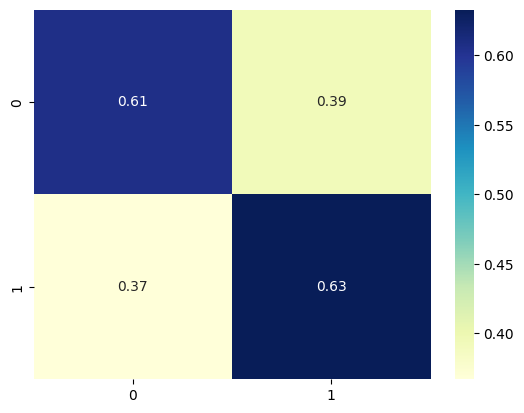

In [116]:
print('Performance on Train Set')
our_metrics(y_train_tree, y_pred_train_eec_best)

Performance on Test Set
Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.6094
_____________________
F1-score: 0.2041
_____________________
Fbeta_score with beta=1.5: 0.2762
_____________________
Fbeta_score with beta=2: 0.3443
_____________________
Fbeta_score with beta=3: 0.4465
_____________________
Recall 0.6349
_____________________
Specificity 0.6072


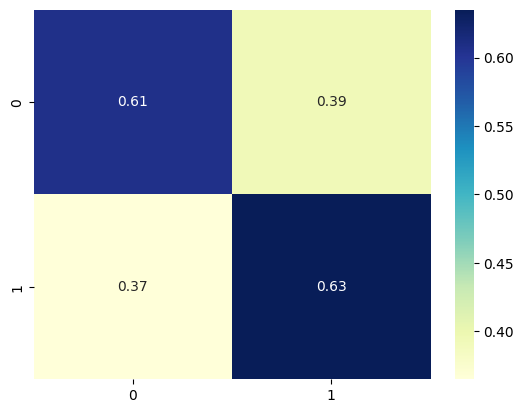

In [117]:
# get performance metrics
print('Performance on Test Set')
our_metrics(y_test_tree, y_pred_eec_best)
# print confusion matrix
# print(confusion_matrix(y_test, y_pred))

The model with the tuned hyperparameters performs slightly better (w.r.t. all the decision metrics) than the EEC with the default settings.

In [14]:
# roc-auc-score of train (small subsample)
print(f'Test ROC AUC Score: {roc_auc_score(y_test_tree, y_pred_eec_best)}')

Test ROC AUC Score: 0.6210741899986002


## Hyperparameter tuning with the F1.5 Scorer

In [124]:
# Instantiate random search and define the metric to optimize 
rs_f15 = RandomizedSearchCV(EasyEnsembleClassifier(random_state=RSEED), param_grid, scoring=f15_scorer,
                  cv=5, verbose=5, n_jobs=1, n_iter=10, random_state=RSEED) 

In [125]:
# Fit randomized search object to data
rs_f15.fit(X_train_tree_small, y_train_tree_small)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END n_estimators=14, replacement=True, sampling_strategy=auto;, score=0.273 total time= 1.1min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END n_estimators=14, replacement=True, sampling_strategy=auto;, score=0.274 total time= 1.1min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END n_estimators=14, replacement=True, sampling_strategy=auto;, score=0.278 total time= 1.1min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END n_estimators=14, replacement=True, sampling_strategy=auto;, score=0.274 total time= 1.1min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END n_estimators=14, replacement=True, sampling_strategy=auto;, score=0.279 total time= 1.1min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END n_estimators=10, replacement=True, sampling_strategy=auto;, score=0.273 total time=  47.9s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END n_estimators=10, replacement=True, sampling_strategy=auto;, score=0.274 total time=  49.7s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END n_estimators=10, replacement=True, sampling_strategy=auto;, score=0.277 total time=  48.6s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END n_estimators=10, replacement=True, sampling_strategy=auto;, score=0.274 total time=  48.1s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END n_estimators=10, replacement=True, sampling_strategy=auto;, score=0.279 total time=  48.0s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END n_estimators=12, replacement=True, sampling_strategy=1;, score=0.273 total time=  57.0s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END n_estimators=12, replacement=True, sampling_strategy=1;, score=0.274 total time=  57.1s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END n_estimators=12, replacement=True, sampling_strategy=1;, score=0.278 total time=  57.1s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END n_estimators=12, replacement=True, sampling_strategy=1;, score=0.274 total time=  56.8s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END n_estimators=12, replacement=True, sampling_strategy=1;, score=0.279 total time=  56.9s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END n_estimators=10, replacement=True, sampling_strategy=1;, score=0.273 total time=  47.8s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END n_estimators=10, replacement=True, sampling_strategy=1;, score=0.274 total time=  48.0s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END n_estimators=10, replacement=True, sampling_strategy=1;, score=0.277 total time=  47.4s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END n_estimators=10, replacement=True, sampling_strategy=1;, score=0.274 total time=  47.3s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END n_estimators=10, replacement=True, sampling_strategy=1;, score=0.279 total time=  46.9s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END n_estimators=8, replacement=False, sampling_strategy=1;, score=0.274 total time=  37.9s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END n_estimators=8, replacement=False, sampling_strategy=1;, score=0.274 total time=  37.8s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END n_estimators=8, replacement=False, sampling_strategy=1;, score=0.278 total time=  37.9s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END n_estimators=8, replacement=False, sampling_strategy=1;, score=0.273 total time=  37.9s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END n_estimators=8, replacement=False, sampling_strategy=1;, score=0.278 total time=  38.2s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END n_estimators=8, replacement=True, sampling_strategy=auto;, score=0.274 total time=  38.0s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END n_estimators=8, replacement=True, sampling_strategy=auto;, score=0.274 total time=  38.6s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END n_estimators=8, replacement=True, sampling_strategy=auto;, score=0.277 total time=  38.2s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END n_estimators=8, replacement=True, sampling_strategy=auto;, score=0.274 total time=  38.3s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END n_estimators=8, replacement=True, sampling_strategy=auto;, score=0.279 total time=  38.1s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END n_estimators=14, replacement=True, sampling_strategy=0.8;, score=0.270 total time= 1.2min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END n_estimators=14, replacement=True, sampling_strategy=0.8;, score=0.272 total time= 1.2min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END n_estimators=14, replacement=True, sampling_strategy=0.8;, score=0.273 total time= 1.2min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END n_estimators=14, replacement=True, sampling_strategy=0.8;, score=0.269 total time= 1.2min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END n_estimators=14, replacement=True, sampling_strategy=0.8;, score=0.274 total time= 1.2min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END n_estimators=14, replacement=False, sampling_strategy=auto;, score=0.273 total time= 1.1min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END n_estimators=14, replacement=False, sampling_strategy=auto;, score=0.274 total time= 1.1min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END n_estimators=14, replacement=False, sampling_strategy=auto;, score=0.277 total time= 1.1min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END n_estimators=14, replacement=False, sampling_strategy=auto;, score=0.273 total time= 1.1min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END n_estimators=14, replacement=False, sampling_strategy=auto;, score=0.278 total time= 1.1min


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END n_estimators=10, replacement=False, sampling_strategy=auto;, score=0.274 total time=  47.8s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END n_estimators=10, replacement=False, sampling_strategy=auto;, score=0.274 total time=  47.7s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END n_estimators=10, replacement=False, sampling_strategy=auto;, score=0.278 total time=  47.4s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END n_estimators=10, replacement=False, sampling_strategy=auto;, score=0.274 total time=  47.3s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END n_estimators=10, replacement=False, sampling_strategy=auto;, score=0.278 total time=  48.0s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END n_estimators=6, replacement=False, sampling_strategy=auto;, score=0.274 total time=  28.7s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END n_estimators=6, replacement=False, sampling_strategy=auto;, score=0.274 total time=  28.6s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END n_estimators=6, replacement=False, sampling_strategy=auto;, score=0.278 total time=  28.8s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END n_estimators=6, replacement=False, sampling_strategy=auto;, score=0.274 total time=  28.8s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END n_estimators=6, replacement=False, sampling_strategy=auto;, score=0.278 total time=  29.0s


/Users/lanacasselmann/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=5, estimator=EasyEnsembleClassifier(random_state=42),
                   n_jobs=1,
                   param_distributions={'n_estimators': [6, 8, 10, 12, 14],
                                        'replacement': [False, True],
                                        'sampling_strategy': ['auto', 0.8, 1]},
                   random_state=42, scoring=make_scorer(fbeta_score, beta=1.5),
                   verbose=5)

In [126]:
# Best score
print('Best score (F1.5):', round(rs_f15.best_score_, 3))

# Best parameters
print('Best parameters (F1.5):', rs_f15.best_params_)

# Best score (F2): 0.344
# Best parameters: {'sampling_strategy': 'auto', 'replacement': False, 'n_estimators': 6}

Best score (F1.5): 0.276
Best parameters (F1.5): {'sampling_strategy': 'auto', 'replacement': False, 'n_estimators': 6}


The best hyper parameters are the same as with F2 scorer: {'sampling_strategy': 'auto', 'replacement': False, 'n_estimators': 6}. Hence, there is no need to train a new model.

In [127]:
# # Assigning the fitted EasyEnsemble model with best parameter combination to a new variable sgd_best_rs
# eec_best_rs_15 = rs_f15.best_estimator_
# # Making predictions on the test set
# y_pred_test_eec_rs_f15 = eec_best_rs_15.predict(X_test_tree)

In [128]:
# pd.DataFrame(rs_f15.cv_results_)

## Training an EasyEnsembleClassifier with the best Hyperparameters

There is no need to train a new model since the hyperparameters are the same, we would obtain the same result.

In [129]:
# # train an EEC on the whole data set with the hyperparameters determined in the F1.5-scored RandomizedSearch 
# # with the partial data set.

# # initiate EasyEnsembleClassifier with the best hyperparameters
# eec_best_f15 = EasyEnsembleClassifier(random_state=RSEED, sampling_strategy='auto', replacement=False, n_estimators=6)
# # fit eec to train data
# eec_best_f15.fit(X_train_tree, y_train_tree)

In [ ]:
# # make prediction on test data
# y_pred_eec_best_f15 = eec_best_f15.predict(X_test_tree)
# # make prediction on train data
# y_pred_train_eec_best_f15 = eec_best_f15.predict(X_train_tree)
# print('Performance on Train Set')
# our_metrics(y_train_tree, y_pred_train_eec_best_f15)
# # get performance metrics
# print('Performance on Test Set')
# our_metrics(y_test_tree, y_pred_eec_best_f15)
# # print confusion matrix
# # print(confusion_matrix(y_test, y_pred))

## GridSearch

In [ ]:
#eec_rs = EasyEnsembleClassifier(random_state=RSEED)

In [ ]:
# GridSearch
# gs = GridSearchCV(SGDClassifier(random_state=RSEED), param_grid, scoring='accuracy',
#                   cv=5, verbose=5, n_jobs=-1)

# # Fit gridsearch object to data.
# gs.fit(X_train_preprocessed, y_train)

# # Best score
# print('Best score:', round(gs.best_score_, 3))

# # Best parameters
# print('Best parameters:', gs.best_params_)

# # Assigning the fitted SGDClassifier model with best parameter combination to a new variable sgd_best
# sgd_best = gs.best_estimator_

# # Making predictions on the test set
# y_pred_test = sgd_best.predict(X_test_preprocessed)
# # Let us print out the performance of our model on the test set.
# sgd_accuracy = print_pretty_summary('SGDClassifier model', sgd_best, y_test, y_pred_test)

## Error Analysis for the trained Model

In [ ]:
# eec_best: EEC with the best hyperparameters, trained on X_train_tree, y_train_tree
# y_pred_eec_best predictions of eec_best on X_test_tree
# y_pres_train_eec_best: predictions of eec_best on y_train_tree

In [ ]:
# plot roc

In [28]:
test_proba_49 = class_metrics_var_threshold(eec_best, X_test_tree, y_test_tree, threshold=0.49)

____________________
Confusion Matrix :
[[  19064 1011832]
 [    153   88124]]
____________________
Accuracy Score : 0.0957742904805602
____________________
Report : 
              precision    recall  f1-score   support

           0       0.99      0.02      0.04   1030896
           1       0.08      1.00      0.15     88277

    accuracy                           0.10   1119173
   macro avg       0.54      0.51      0.09   1119173
weighted avg       0.92      0.10      0.05   1119173

____________________


Changing the threshold slightly does not improve the model:
* changing the threshold to 0.6 is equivalent to predicting no one commits fraud
* changing the threshold to 0.49 yields a lot of true positives, hardly any false negatives. However, this comes at the price of a lot of false positive predictions. 

In [13]:
# get scorers for different thresholds
test_proba = class_metrics_var_threshold(eec_best, X_test_tree, y_test_tree, threshold=0.5)


____________________
Confusion Matrix :
[[625964 404932]
 [ 32226  56051]]
____________________
Accuracy Score : 0.6093919349376727
____________________
Report : 
              precision    recall  f1-score   support

           0       0.95      0.61      0.74   1030896
           1       0.12      0.63      0.20     88277

    accuracy                           0.61   1119173
   macro avg       0.54      0.62      0.47   1119173
weighted avg       0.89      0.61      0.70   1119173

____________________


### Error Analysis on Test Set

In [22]:
type(y_test_tree)

numpy.ndarray

In [20]:
# turn test_proba into DataFrame
df_proba = pd.DataFrame(data=test_proba, columns=['no_fraud_proba','fraud_proba'])

In [23]:
df_y_test = pd.DataFrame(data=y_test_tree, columns=['target'])

In [24]:
df_y_test_pred = pd.DataFrame(data=y_pred_eec_best, columns=['fraud_pred'])

In [25]:
# make DataFrame containing the test data and predictions of it
df_test = pd.concat([X_test_tree, df_y_test, df_y_test_pred, df_proba], axis=1)

In [26]:
df_test.head()

,member_years,index_change_month,quantity_counters,client_catg_11,client_catg_12,client_catg_51,region_101,region_103,region_104,region_105,...,reading_remarque_6,reading_remarque_7,reading_remarque_8,reading_remarque_9,counter_type_ELEC,counter_type_GAZ,target,fraud_pred,no_fraud_proba,fraud_proba
0,11,17.000,58,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0.499381,0.500619
1,5,20.375,68,1,0,0,0,1,0,0,...,1,0,0,0,0,1,0,1,0.496718,0.503282
2,4,0.000,48,0,0,1,0,0,1,0,...,1,0,0,0,0,1,0,1,0.498331,0.501669
3,28,415.500,62,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,1,0.499155,0.500845
4,20,5.750,60,1,0,0,0,1,0,0,...,0,0,1,0,0,1,0,1,0.495342,0.504658


In [39]:
df_test['pred_corr']= (df_test['target'] == df_test['fraud_pred'])

In [ ]:
df_test['pred_corr']= (df_test['target'] == df_test['fraud_pred'])

In [40]:
df_test.head()

,member_years,index_change_month,quantity_counters,client_catg_11,client_catg_12,client_catg_51,region_101,region_103,region_104,region_105,...,reading_remarque_7,reading_remarque_8,reading_remarque_9,counter_type_ELEC,counter_type_GAZ,target,fraud_pred,no_fraud_proba,fraud_proba,pred_corr
0,11,17.000,58,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0.499381,0.500619,False
1,5,20.375,68,1,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0.496718,0.503282,False
2,4,0.000,48,0,0,1,0,0,1,0,...,0,0,0,0,1,0,1,0.498331,0.501669,False
3,28,415.500,62,1,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0.499155,0.500845,False
4,20,5.750,60,1,0,0,0,1,0,0,...,0,1,0,0,1,0,1,0.495342,0.504658,False


In [29]:
df_false_pred = df_test.query('target != fraud_pred')

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
# regions not of relevance
# 305      94276
# 307      85531
# 313      76924
# 105      53131
# 371      53021
# 308      28699
# 106      24212
# 372      17013
# 379      13255
# 399       1566
# 206       1004
# 199          2

In [37]:
pd.set_option('display.max_rows', None)
display(df_false_pred.groupby('target').describe().T)

target                                0             1
member_years       count  404932.000000  32226.000000
                   mean       17.286337     12.452057
                   std        10.136763      9.806865
                   min         0.000000      0.000000
                   25%         8.000000      5.000000
                   50%        17.000000     10.000000
                   75%        25.000000     19.000000
                   max        42.000000     42.000000
index_change_month count  404932.000000  32226.000000
                   mean      200.954188    114.497452
                   std      3408.063564    544.278680
                   min   -996608.000000 -24876.500000
                   25%        20.750000     20.500000
                   50%        71.500000     78.000000
                   75%       176.281250    148.750000
                   max     74169.000000  10483.000000
quantity_counters  count  404932.000000  32226.000000
                   mean       64.313225     48.759759
                   std        30.269453     21.452984
                   min         6.000000      1.000000
                   25%        42.000000     32.000000
                   50%        62.000000     47.000000
                   75%        76.000000     67.000000
                   max       272.000000    171.000000
client_catg_11     count  404932.000000  32226.000000
                   mean        0.948831      0.976013
                   std         0.220343      0.153010
                   min         0.000000      0.000000
                   25%         1.000000      1.000000
                   50%         1.000000      1.000000
                   75%         1.000000      1.000000
                   max         1.000000      1.000000
client_catg_12     count  404932.000000  32226.000000
                   mean        0.007110      0.019208
                   std         0.084020      0.137258
                   min         0.000000      0.000000
                   25%         0.000000      0.000000
                   50%         0.000000      0.000000
                   75%         0.000000      0.000000
                   max         1.000000      1.000000
client_catg_51     count  404932.000000  32226.000000
                   mean        0.044059      0.004779
                   std         0.205227      0.068964
                   min         0.000000      0.000000
                   25%         0.000000      0.000000
                   50%         0.000000      0.000000
                   75%         0.000000      0.000000
                   max         1.000000      1.000000
region_101         count  404932.000000  32226.000000
                   mean        0.050557      0.340098
                   std         0.219091      0.473749
                   min         0.000000      0.000000
                   25%         0.000000      0.000000
                   50%         0.000000      0.000000
                   75%         0.000000      1.000000
                   max         1.000000      1.000000
region_103         count  404932.000000  32226.000000
                   mean        0.144523      0.007230
                   std         0.351620      0.084724
                   min         0.000000      0.000000
                   25%         0.000000      0.000000
                   50%         0.000000      0.000000
                   75%         0.000000      0.000000
                   max         1.000000      1.000000
region_104         count  404932.000000  32226.000000
                   mean        0.087459      0.091913
                   std         0.282507      0.288908
                   min         0.000000      0.000000
                   25%         0.000000      0.000000
                   50%         0.000000      0.000000
                   75%         0.000000      0.000000
                   max         1.000000      1.000000
region_105         count  404932.000000  32226.000000
    

In [42]:
display(df_test.groupby('pred_corr').describe().T)

pred_corr                         False          True 
member_years       count  437158.000000  682015.000000
                   mean       16.929968      11.614654
                   std        10.191395       9.620570
                   min         0.000000       0.000000
                   25%         8.000000       4.000000
                   50%        16.000000       9.000000
                   75%        25.000000      17.000000
                   max        42.000000      42.000000
index_change_month count  437158.000000  682015.000000
                   mean      194.580852     135.039329
                   std      3283.447417     901.874224
                   min   -996608.000000 -237774.250000
                   25%        20.750000      19.000000
                   50%        72.000000      79.000000
                   75%       173.500000     150.750000
                   max     74169.000000  116645.000000
quantity_counters  count  437158.000000  682015.000000
                   mean       63.166670      47.469597
                   std        29.985686      28.455375
                   min         1.000000       1.000000
                   25%        41.000000      28.000000
                   50%        62.000000      43.000000
                   75%        76.000000      66.000000
                   max       272.000000     439.000000
client_catg_11     count  437158.000000  682015.000000
                   mean        0.950835       0.968719
                   std         0.216213       0.174076
                   min         0.000000       0.000000
                   25%         1.000000       1.000000
                   50%         1.000000       1.000000
                   75%         1.000000       1.000000
                   max         1.000000       1.000000
client_catg_12     count  437158.000000  682015.000000
                   mean        0.008002       0.019555
                   std         0.089094       0.138466
                   min         0.000000       0.000000
                   25%         0.000000       0.000000
                   50%         0.000000       0.000000
                   75%         0.000000       0.000000
                   max         1.000000       1.000000
client_catg_51     count  437158.000000  682015.000000
                   mean        0.041164       0.011726
                   std         0.198669       0.107648
                   min         0.000000       0.000000
                   25%         0.000000       0.000000
                   50%         0.000000       0.000000
                   75%         0.000000       0.000000
                   max         1.000000       1.000000
region_101         count  437158.000000  682015.000000
                   mean        0.071901       0.346809
                   std         0.258324       0.475955
                   min         0.000000       0.000000
                   25%         0.000000       0.000000
                   50%         0.000000       0.000000
                   75%         0.000000       1.000000
                   max         1.000000       1.000000
region_103         count  437158.000000  682015.000000
                   mean        0.134402       0.022017
                   std         0.341084       0.146739
                   min         0.000000       0.000000
                   25%         0.000000       0.000000
                   50%         0.000000       0.000000
                   75%         0.000000       0.000000
                   max         1.000000       1.000000
region_104         count  437158.000000  682015.000000
                   mean        0.087787       0.090728
                   std         0.282986       0.287222
                   min         0.000000       0.000000
                   25%         0.000000       0.000000
                   50%         0.000000       0.000000
                   75%         0.000000       0.000000
                   max         1.000000 

In [43]:
# True positive rate: TP/(TP+FN) = 0.63
tpr = 0.63
# False positive rate: FP/(TN+FP) = 0.39
fpr = 0.39
# target value count
# 0    4123581
# 1     353109
total_loss = 200000000
num_fraud = 353109
avg_loss = total_loss / num_fraud
cost_falsely_acc = 0
gain_per_client = avg_loss * tpr - cost_falsely_acc * fpr

566.397344729248

In [45]:
# expected gain during next period by detecting fraud in 63% of the fraud cases
total_gain = 0.63 * total_loss
total_gain

126000000.0